In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In /Users/niomoo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/niomoo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/niomoo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/niomoo/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/niomoo/opt/anaconda3/lib/pytho

In [2]:
def import_data():
    raw_data_df = pd.read_csv("datasets/preprocessed_data.csv", header=0)
    return raw_data_df

In [3]:
data = import_data()

In [4]:
data.head()

,Date,Net Peak Capability(MW),Peak Load(MW),Operating Reserve(MW),Operating Reserve Percent(%)
0,20200101,28125,25335,2790,11.01
1,20200102,31303,28223,3080,10.91
2,20200103,31676,28292,3384,11.96
3,20200104,29219,25583,3636,14.21
4,20200105,27456,24761,2695,10.88


In [5]:
date_time = pd.to_datetime(data.pop('Date'), format='%Y%m%d')

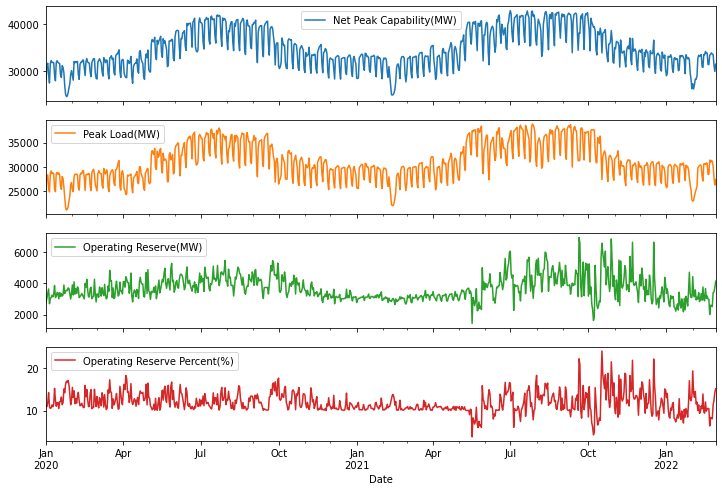

In [6]:
plot_cols = ['Net Peak Capability(MW)', 'Peak Load(MW)', 'Operating Reserve(MW)', 'Operating Reserve Percent(%)']
plot_feature = data[plot_cols]
plot_feature.index = date_time
_ = plot_feature.plot(figsize=(12, 8), subplots=True)

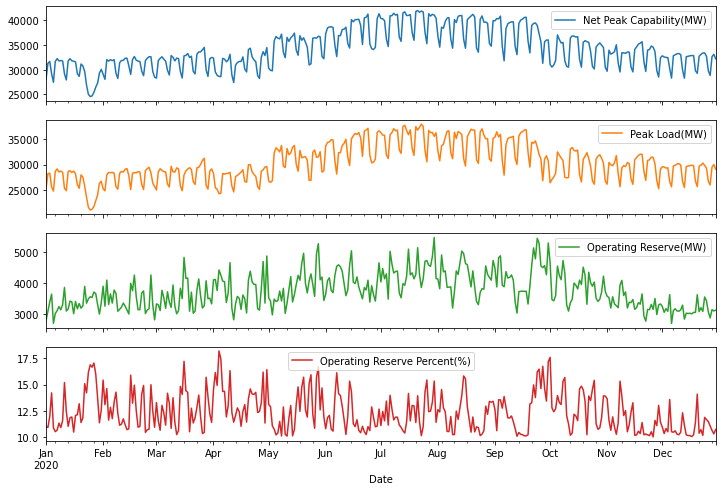

In [7]:
plot_features = data[plot_cols][:365]
plot_features.index = date_time[:365]
_ = plot_features.plot(figsize=(12, 8),subplots=True)

In [8]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
raw_data_df = pd.read_csv("datasets/preprocessed_data.csv")
df = pd.DataFrame(raw_data_df)
date_time = pd.to_datetime(df.pop('Date'), format='%Y%m%d')
df['Operating Reserve(MW)'] = pd.to_numeric(df['Operating Reserve(MW)'], downcast='float', errors='coerce')
arima_data = df['Operating Reserve(MW)']
arima_data.index = date_time

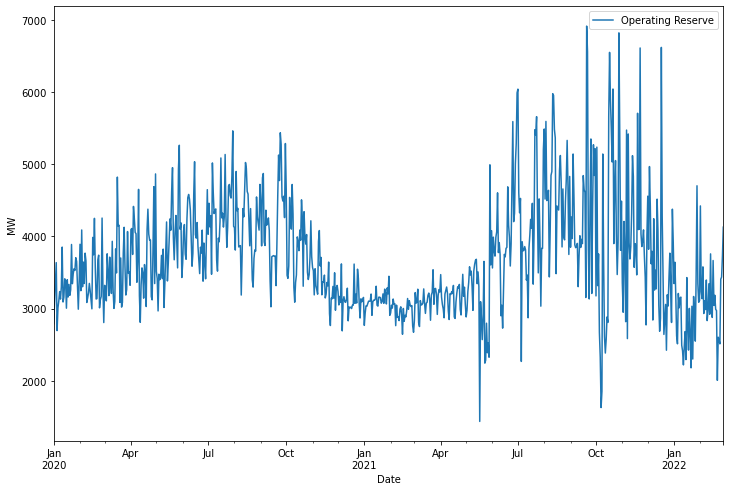

In [11]:
arima_data.plot(figsize=(12, 8), label='Operating Reserve')
plt.ylabel('MW')
plt.legend()
plt.show()

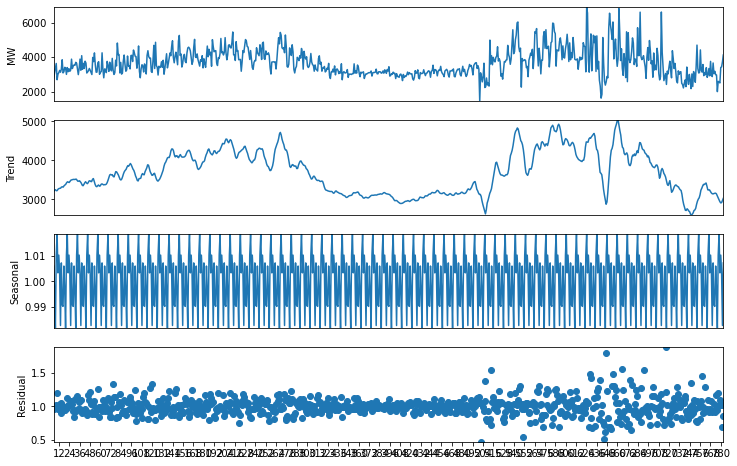

In [12]:
result = seasonal_decompose(arima_data, model='multiplicative', freq=12)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(result.observed, label='Operating Reserve')
plt.ylabel('MW')
plt.xticks(df.index[::12], rotation=0)
plt.margins(0)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel('Trend')
plt.xticks(df.index[::12], rotation=0)
plt.margins(0)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel('Seasonal')
plt.xticks(df.index[::12], rotation=0)
plt.margins(0)
plt.subplot(4,1,4)
plt.scatter(df.index,result.resid)
plt.ylabel('Residual')
plt.xticks(df.index[::12], rotation=0)
plt.margins(0)

In [13]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  

    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")

In [14]:
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                  -2.160106
p-value                          0.221042
#Lags Used                      21.000000
Number of Observations Used    768.000000
Criterical Value (1%)           -3.438893
Criterical Value (5%)           -2.865311
Criterical Value (10%)          -2.568778
dtype: float64
The data is non-stationary, so do differencing!


In [29]:
diff_1 = arima_data - arima_data.shift(1) 
diff_1 = diff_1.dropna()
diff_1.head()

Date
2020-01-02    290.0
2020-01-03    304.0
2020-01-04    252.0
2020-01-05   -941.0
2020-01-06    314.0
Name: Operating Reserve(MW), dtype: float32

Results of Dickey-Fuller Test
Test Statistic                -1.108158e+01
p-value                        4.297974e-20
#Lags Used                     2.000000e+01
Number of Observations Used    7.680000e+02
Criterical Value (1%)         -3.438893e+00
Criterical Value (5%)         -2.865311e+00
Criterical Value (10%)        -2.568778e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


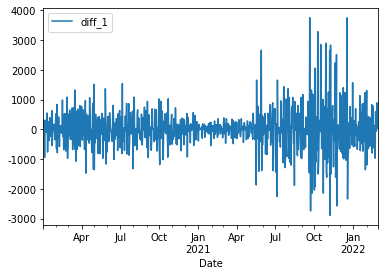

In [30]:
diff_1.plot(figsize=(6,4), label='diff_1')
plt.legend()

adf_test(diff_1)

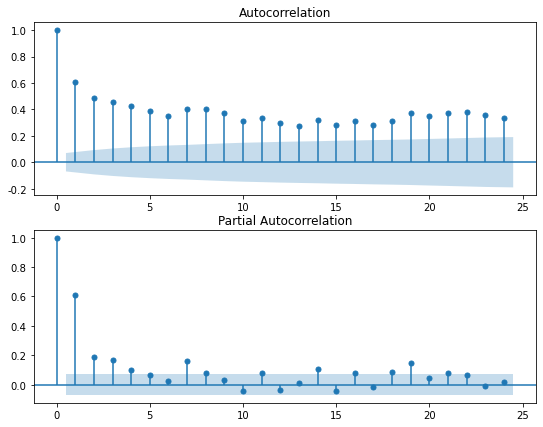

In [16]:
f = plt.figure(facecolor='white', figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(arima_data, lags=24, ax=ax2)
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

In [17]:
def arima_AIC(data, p=4, d=3, q=4):
    best_AIC =["pdq",1000000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):            
                model = ARIMA(data, order=(i,j,k))
                fitted = model.fit(disp=-1)
                AIC.append(fitted.aic)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k})：AIC={fitted.aic}")
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})"
                    best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.show()

ARIMA(0,1,0)：AIC=12545.556131043306
ARIMA(0,1,1)：AIC=12344.148386365752
ARIMA(0,1,2)：AIC=12304.607086685884
ARIMA(1,1,0)：AIC=12444.892273927475
ARIMA(1,1,1)：AIC=12294.503189176083
ARIMA(1,1,2)：AIC=12294.695352995679
ARIMA(2,1,0)：AIC=12389.524714224977
ARIMA(2,1,1)：AIC=12295.255488542653
ARIMA(2,1,2)：AIC=12295.934908084022
ARIMA(3,1,0)：AIC=12369.54401935606
ARIMA(3,1,1)：AIC=12294.899914587973
ARIMA(3,1,2)：AIC=12295.51094928546
This best model is ARIMA(1,1,1) based on argmin AIC.


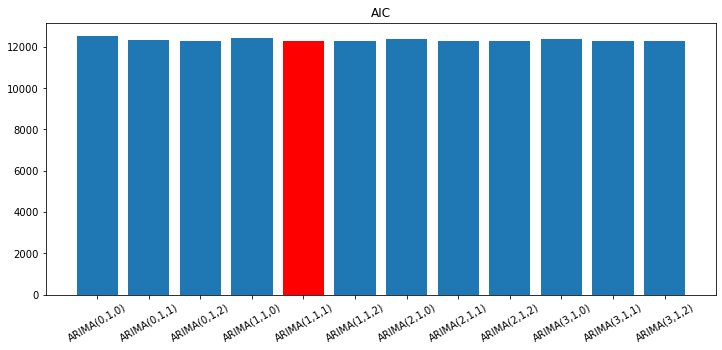

In [18]:
arima_AIC(arima_data, 4,2,3)

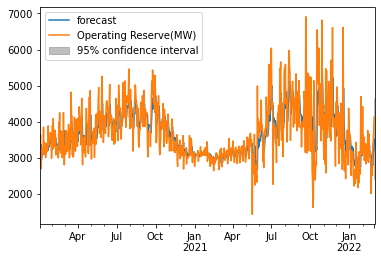

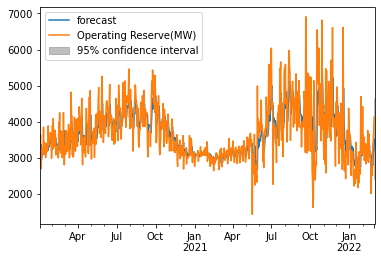

In [19]:
model = ARIMA(arima_data, order=(1, 1, 1)) #修改 p,d,q參數 
fitted = model.fit(disp=-1) 
fitted.plot_predict(1,len(df))

In [20]:
def arima_mse(data, p=4, d=3, q=4):
    period = 3
    best_pdq =["pdq",1000000]
    L =len(data)
    train = data[:(L-period)]
    test = data[-period:]
    mse_r = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):            
                model = ARIMA(train, order=(i,j,k))
                fitted = model.fit(disp=-1)
                fc, se, conf = fitted.forecast(period, alpha=0.05)  
                mse = mean_squared_error(test,fc)
                mse_r.append(mse)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k})：MSE={mse}")
                if mse < best_pdq[1]:
                    best_pdq[0] = f"ARIMA({i},{j},{k})"
                    best_pdq[1] = mse
    print("==========================================================================")
    print(f"This best model is {best_pdq[0]} based on argmin MSE.")
    plt.figure(figsize=(12,5))
    plt.bar(name, mse_r)
    plt.bar(best_pdq[0], best_pdq[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("MSE")
    plt.show()

ARIMA(0,1,0)：MSE=207110.65426559388
ARIMA(0,1,1)：MSE=908594.3087258801
ARIMA(0,1,2)：MSE=687545.1844399123
ARIMA(1,1,0)：MSE=440421.90261780703
ARIMA(1,1,1)：MSE=591627.7934018732
ARIMA(1,1,2)：MSE=576641.1937216343
ARIMA(2,1,0)：MSE=617362.7177798965
ARIMA(2,1,1)：MSE=577938.1392229861
ARIMA(2,1,2)：MSE=598028.4534226378
This best model is ARIMA(0,1,0) based on argmin MSE.


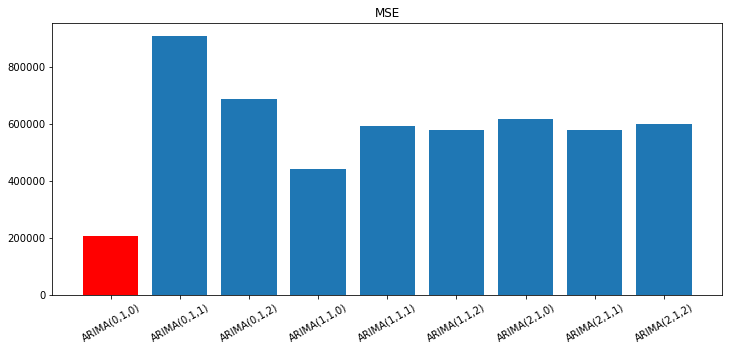

In [21]:
arima_mse(arima_data, 3,2,3)

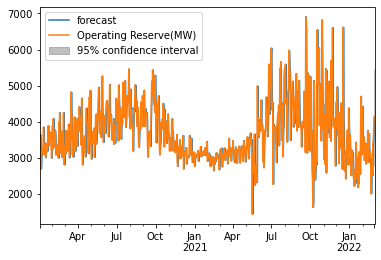

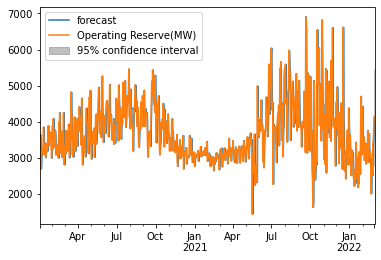

In [22]:
model = ARIMA(arima_data, order=(0, 1, 0)) #修改 p,d,q參數 
fitted = model.fit(disp=-1) 
fitted.plot_predict(1,len(df))

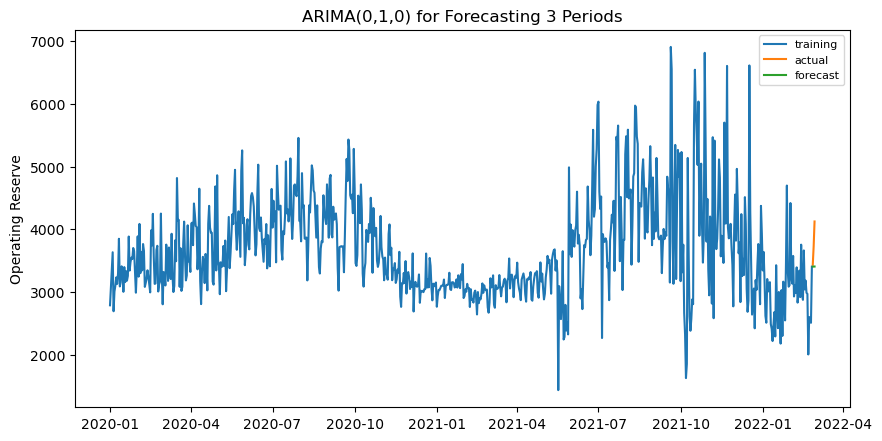

In [23]:
#data spilt
period = 3
title = f'ARIMA(0,1,0) for Forecasting {period} Periods'
L = len(arima_data)
x_train = arima_data[:(L-period)]
x_test = arima_data[-period:]
#Build Model 
model = ARIMA(x_train, order=(0, 1, 0)) 
fitted = model.fit(disp=-1)
#Forecast
fc, se, conf = fitted.forecast(period, alpha=0.05) # 95% conf
#Make as pandas series
fc_series = pd.Series(fc, index=x_test.index)
#Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title(title)
plt.ylabel('Operating Reserve')
plt.legend(loc='upper right', fontsize=8)
plt.show()

In [24]:
#Results
print(f'Mean Absolute Error : {mean_absolute_error(fc_series,x_test)}')
print(f'Mean Squared Error : {mean_squared_error(fc_series,x_test)}')
print('===========================') 
print('fc_series:',fc_series)
print('===========================')
print('Operating Reserve',x_test)

Mean Absolute Error : 357.0992366412217
Mean Squared Error : 207110.65426559388
fc_series: Date
2022-02-26    3406.783715
2022-02-27    3407.567430
2022-02-28    3408.351145
dtype: float64
Operating Reserve Date
2022-02-26    3437.0
2022-02-27    3730.0
2022-02-28    4127.0
Name: Operating Reserve(MW), dtype: float32


In [25]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                
===================================================================================
Dep. Variable:     D.Operating Reserve(MW)   No. Observations:                  786
Model:                      ARIMA(0, 1, 0)   Log Likelihood               -6248.174
Method:                                css   S.D. of innovations            685.667
Date:                     Wed, 30 Mar 2022   AIC                          12500.348
Time:                             01:38:17   BIC                          12509.682
Sample:                         01-02-2020   HQIC                         12503.937
                              - 02-25-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7837     24.457      0.032      0.974     -47.151      48.718
==============================================================================
"""

In [26]:
test_data = [{"Date": '20220330'},
             {"Date": '20220331'},
             {"Date": '20220401'},
             {"Date": '20220402'},
             {"Date": '20220403'},   
             {"Date": '20220404'},
             {"Date": '20220405'},
             {"Date": '20220406'},
             {"Date": '20220407'},
             {"Date": '20220408'},
             {"Date": '20220409'},
             {"Date": '20220410'},
             {"Date": '20220411'},
             {"Date": '20220412'},
             {"Date": '20220413'}]
x_test = pd.DataFrame(test_data)
date_time = pd.to_datetime(x_test.pop('Date'), format='%Y%m%d')
x_test.index = date_time

In [36]:
period = 15
#Forecast
fc, se, conf = fitted.forecast(period, alpha=0.05) # 95% conf
#Make as pandas series
fc_series = pd.Series(fc, index=x_test.index)
fc_series.head(15)

Date
2022-03-30    3406.783715
2022-03-31    3407.567430
2022-04-01    3408.351145
2022-04-02    3409.134860
2022-04-03    3409.918575
2022-04-04    3410.702290
2022-04-05    3411.486005
2022-04-06    3412.269720
2022-04-07    3413.053435
2022-04-08    3413.837150
2022-04-09    3414.620865
2022-04-10    3415.404580
2022-04-11    3416.188295
2022-04-12    3416.972010
2022-04-13    3417.755725
dtype: float64

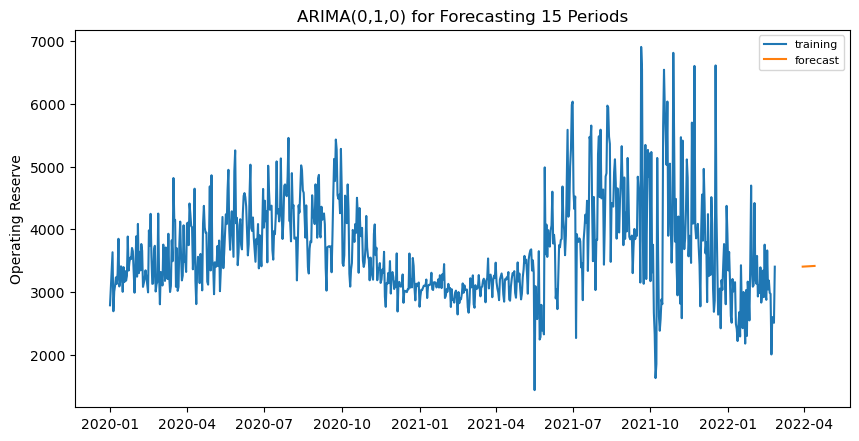

In [34]:
period = 15
title = f'ARIMA(0,1,0) for Forecasting {period} Periods'
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x_train, label='training')
plt.plot(fc_series, label='forecast')
plt.title(title)
plt.ylabel('Operating Reserve')
plt.legend(loc='upper right', fontsize=8)
plt.show()